# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here
%matplotlib inline 
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sb
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader as DL
from torchvision import datasets, transforms, models
from workspace_utils import active_session

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_data_transforms = transforms.Compose([transforms.RandomRotation(45),
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])])

valid_data_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])])

test_data_transforms = valid_data_transforms

# TODO: Load the datasets with ImageFolder
train_image_dataset = datasets.ImageFolder(train_dir, transform=train_data_transforms)
valid_image_dataset = datasets.ImageFolder(valid_dir, transform=valid_data_transforms)
test_image_dataset = datasets.ImageFolder(test_dir, transform=test_data_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloader = DL(train_image_dataset, batch_size=64, shuffle=True)
valid_dataloader = DL(valid_image_dataset, batch_size=64)
test_dataloader = DL(test_image_dataset, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [5]:
# The validation function could have been included in the <deep_learning> function as well, 
# But as it will be used for validation and testing, it's more sophisticated to wrap it into
# A separate function so that it can be reused. 

def validation(model, dataloader, criterion, device='cpu'):
    loss = 0
    accuracy = 0
    
    #01. Loop through the dataloader (i.e. validation or testing)
    for images, labels in dataloader:
        
        #02. Move the environment to the specified device 
        model.to(device)
        images = images.to(device)
        labels = labels.to(device)
        
        #03. Forward pass
        output = model.forward(images)
        
        #04. Loss calculation (only the loss item itself because backpropagation is not needed here)
        loss += criterion(output, labels).item()
        
        #05. Calculate the probability (exponential is used, because the output is a LogSoftmax)
        probability = torch.exp(output)
        
        #06. Check where the probablity output matches the input labels 
        equality = (labels.data == probability.max(dim=1)[1])
        
        #07. Calculate accuracy (equality returns a list of ones and zeros; so the mean is the accuracy)
        accuracy += equality.type(torch.cuda.FloatTensor if device=='cuda' else torch.FloatTensor).mean()
  
    #08. Return <loss> and <accuracy> as the result of the validation function
    return loss, accuracy

In [6]:
# This code could have been written in the section <TODO: Build and train your network> under point #08.
# But wrap it into a formula as demonstrated in the classroom under <Lesson 4: Deep Learning with PyTorch - Learning Transfer>
# Is just much more elegant. Therefore, it has to be defined before usage. 

def deep_learning(model, train_dataloader, valid_dataloader, epochs, print_interval, criterion, optimizer, device='cpu'):
    
    model.train()
    step = 0
    
    #01. Loop through the number of epochs
    for e in range(epochs):
        
        #02. Reset the running loss calculation
        running_loss = 0
        
        #03. Loop through the training data
        for images, labels in train_dataloader:
            step += 1
            
            #04. Move the environment to the specified device 
            model.to(device)
            images = images.to(device)
            labels = labels.to(device)
            
            #05. Make sure to zero out the gradients to avoid accumulation
            optimizer.zero_grad()
            
            #06. Forward pass
            outputs = model.forward(images)
            
            #07. Loss calculation
            loss = criterion(outputs, labels)
            
            #08. Backpropagation
            loss.backward()
            
            #09. Parameter update
            optimizer.step()
            
            #10. Update the running loss
            running_loss += loss.item()
            
            #11. Display the running loss if it's a multiple of the print interval   
            if step % print_interval == 0:
                
                #12. Put the model into evaluation mode
                model.eval()
                
                #13. Disable gradients for the validation to save memory
                with torch.no_grad():
                    valid_loss, valid_accuracy = validation(model, valid_dataloader, criterion, device)
                    
                #14. Print the validation results             
                print('Epoch: {}/{} ¦ '.format(e+1,epochs),
                      'Training Loss: {:.4f} ¦ '.format(running_loss/print_interval),
                      'Validation Loss: {:.4f} ¦ '.format(valid_loss/len(valid_dataloader)),
                      'Validation Accuracy: {:.2%}'.format(valid_accuracy/len(valid_dataloader)))
                
                running_loss = 0
                
                #15. Put the model back into training mode
                model.train()

In [7]:
# TODO: Build and train your network
# 00. Define the hyperparameters
hidden_sizes = [1028, 512]
learning_rate = 0.001
epochs = 4

# 01. Device agnostic code to check whether CUDA is available for fast GPU computation or CPU has to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 02. Make sure that the workspace keeps awake 
with active_session():
    
    # 03. Load the pre-trained VGG16 network 
    model = models.vgg16(pretrained=True)
    
    # print(model)
    # 04. Freeze the model parameters
    for p in model.parameters():
        p.requires_grad = False
        
    # 05. Change the classifier of the VGG16 model to fit our data
    # The default VGG16 model classifier looks as follows:
    # (classifier): Sequential(
    #   (0): Linear(in_features=25088, out_features=4096, bias=True)
    #   (1): ReLU(inplace)
    #   (2): Dropout(p=0.5)
    #   (3): Linear(in_features=4096, out_features=4096, bias=True)
    #   (4): ReLU(inplace)
    #   (5): Dropout(p=0.5)
    #   (6): Linear(in_features=4096, out_features=1000, bias=True)
    #  )
    # Take the number of inputs from VGG16 model (that is 25088)
    # The number of outputs is given by the number of flower categories (that is 102)
    # Use <OrderedDict> to name the individual layers and operations
    
    classifier = nn.Sequential(OrderedDict([
                               ('input_layer',nn.Linear(25088, hidden_sizes[0])),
                               ('relu1',nn.ReLU()),
                               ('drop1',nn.Dropout(p=0.5)),
                               ('hidden_layer1',nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                               ('relu2',nn.ReLU()),
                               ('drop2',nn.Dropout(p=0.5)),
                               ('output_layer',nn.Linear(hidden_sizes[1], 102)),
                               ('softmax',nn.LogSoftmax(dim=1))]))
                               
    model.classifier = classifier
    
    #06. Set the criterion
    criterion = nn.NLLLoss()
    
    #07. Set the optimization algorithm
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    
    #08. Start to train the model
    deep_learning(model, train_dataloader, valid_dataloader, epochs, 25, criterion, optimizer, device.type)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 97255576.61it/s] 


Epoch: 1/4 ¦  Training Loss: 4.5123 ¦  Validation Loss: 3.7749 ¦  Validation Accuracy: 24.05%
Epoch: 1/4 ¦  Training Loss: 3.8623 ¦  Validation Loss: 2.8989 ¦  Validation Accuracy: 35.99%
Epoch: 1/4 ¦  Training Loss: 3.3367 ¦  Validation Loss: 2.1789 ¦  Validation Accuracy: 47.06%
Epoch: 1/4 ¦  Training Loss: 2.8542 ¦  Validation Loss: 1.7498 ¦  Validation Accuracy: 54.76%
Epoch: 2/4 ¦  Training Loss: 2.2404 ¦  Validation Loss: 1.6109 ¦  Validation Accuracy: 58.69%
Epoch: 2/4 ¦  Training Loss: 2.4031 ¦  Validation Loss: 1.3399 ¦  Validation Accuracy: 63.98%
Epoch: 2/4 ¦  Training Loss: 2.3603 ¦  Validation Loss: 1.2404 ¦  Validation Accuracy: 67.47%
Epoch: 2/4 ¦  Training Loss: 2.1739 ¦  Validation Loss: 1.1517 ¦  Validation Accuracy: 68.97%
Epoch: 3/4 ¦  Training Loss: 1.5565 ¦  Validation Loss: 1.0528 ¦  Validation Accuracy: 71.06%
Epoch: 3/4 ¦  Training Loss: 2.0158 ¦  Validation Loss: 0.9980 ¦  Validation Accuracy: 72.28%
Epoch: 3/4 ¦  Training Loss: 1.8715 ¦  Validation Loss: 0.90

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
# TODO: Do validation on the test set

#01. Put the model again into evaluation mode
model.eval()

#02. Disable gradients for testing to save memory
with torch.no_grad():
    test_loss, test_accuracy = validation(model, test_dataloader, criterion, device.type)

#03. Print the testing results
print('Test Loss: {:.4f} ¦ '.format(test_loss/len(test_dataloader)),
      'Test Accuracy: {:.2%}'.format(test_accuracy/len(test_dataloader)))

Test Loss: 0.8981 ¦  Test Accuracy: 76.94%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# TODO: Save the checkpoint 
# First, create a combined dictionary <full_dict> that contains both: class to index and name
full_dict = dict()
for keys, values in train_image_dataset.class_to_idx.items():
    full_dict.update({keys: [values, cat_to_name[keys]]})
    
# Append the full dictionary to the model as described above.
model.full_dict = full_dict

# I will wrap the <save checkpoint> task into a function so that it can be efficiently reused anytime.
def save_checkpoint(model, optimizer, epochs, checkpoint_name):
    #01. Create a checkpoint dictionary <cp> that contains all information to recreate the model architecture
    cp = {'model': model,
          'model_state_dict': model.state_dict(),
          'full_dict': model.full_dict,
          'optimizer': optimizer,
          'optimizer_state_dict': optimizer.state_dict(),
          'epochs': epochs}
    torch.save(cp, checkpoint_name + '.pth')

# Save the checkpoint
save_checkpoint(model, optimizer, epochs, 'checkpoint_pk_1')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# Similar to <save_checkpoint> we just do the same in the opposite direction
def load_checkpoint(checkpoint_name, device='cpu'):
    #01. Load the checkpoint; include the <map_location> as well for proper device handling
    if device == 'cuda':
        device += ':0' 
    cp = torch.load(checkpoint_name + '.pth', map_location=device)
    
    #02. Apply the checkpoint attributes
    model = cp['model']
    model.load_state_dict(cp['model_state_dict'])
    model.full_dict = cp['full_dict']
    optimizer = cp['optimizer']
    optimizer.load_state_dict(cp['optimizer_state_dict'])
    epochs = cp['epochs']
    
    #03. Return the updated results
    return model, optimizer, epochs

# Load the checkpoint
model, optimizer, epochs = load_checkpoint('checkpoint_pk_1', device.type);

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

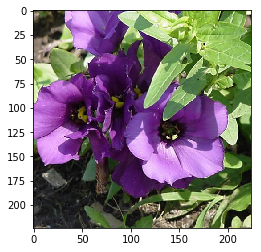

In [19]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    #01. Define parameters
    scale_size = 256
    crop_size = 224
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    #02. Load image
    img = Image.open(image)
    
    #03. Resize image, keeping the aspect ratio
    width, height = img.size
    if width > height:
        img = img.resize((int(width * (crop_size / height)), crop_size))
    else:
        img = img.resize((crop_size, int(height * (crop_size / width))))
    
    #04. Crop image in the center to the required size
    img = img.crop(((img.size[0] - crop_size)/2, (img.size[1] - crop_size)/2,
                    (img.size[0]+ crop_size)/2, (img.size[1] + crop_size)/2))
    
    #05. Convert PIL image to Numpy array
    np_img = np.array(img)

    #06. Normalize the image
    np_img = ((np_img/255) - mean) / std

    #07. Reorder dimensions as required
    np_img = np_img.transpose(2, 0, 1)
    
    #08. Return the Numpy array image as the result
    return np_img

# Test the function: Convert and Re-Convert the test image
img = process_image(r'my_images\bolero_deep_blue.jpg')
imshow(img);

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [2]:
from PIL import Image
img = Image.open(r'my_images\rose.jpg')

In [20]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [21]:
def predict(image_path, model, device='cpu', topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    #01. Put the model into evaluation mode and move it to the appropriate device
    model.eval()
    model.to(device)
    
    #02. Import the image in Numpy array format using the previous function <process_image>
    img = process_image(image_path)
    
    #03. Convert the Numpy image into a tensor on the appropriate device
    img_tensor = torch.from_numpy(img).float().to(device)
    
    #04. Resize the tensor for batching
    img_tensor.unsqueeze_(0)
    
    #05. Forward pass
    output = model.forward(img_tensor)
    
    #06. Calculate the probability (exponential is used, because the output is a LogSoftmax)
    probability = torch.exp(output)
    
    #07. Get the top-K probabilites along with the indices
    probs, indices = torch.topk(probability, topk)
    
    #08. Move the results back to CPU in order to use Numpy and convert it to a list
    probs = probs.to('cpu').detach().numpy()[0]
    indices = indices.to('cpu').detach().numpy()[0]
    
    #09. Invert the attached full dictionary so that the indices are the keys
    full_dict_inverted = dict([[values[0],[keys, values[1]]] for keys, values in model.full_dict.items()])
    
    #10. Get the classes out of the inverted full dictionary
    classes = [full_dict_inverted[i][0] for i in indices]
    
    #11. Return the results
    return probs, classes 

# Test the function
probs, classes = predict(r'my_images\bolero_deep_blue.jpg', model, device.type)
print(probs)
print(classes)

[ 0.3620843   0.25765178  0.06755917  0.06547433  0.05531599]
['3', '28', '51', '9', '55']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

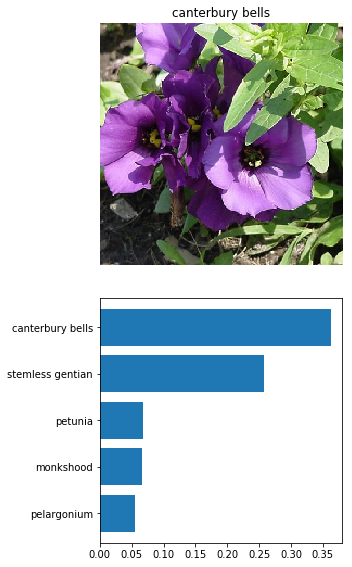

In [22]:
# TODO: Display an image along with the top 5 classes
#01. Load a sample image and process it
img_path = r'my_images\bolero_deep_blue.jpg'
img = process_image(img_path)
probs, classes = predict(img_path, model, device.type)

#02. Get the flower names
names = [full_dict[i][1] for i in classes]

#03. Flip dimensions to show the horizontal bar chart in descending order
probs, names = np.array(np.flip(probs, 0)), np.array(np.flip(names, 0))

#04. Create a figure with two-rows one-column subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8))

#05. Populate the image in the upper plot
ax1.set_title(names[-1])
imshow(img, ax1);
ax1.axis('off')

#06. Populate the horizontal bar chart in the lower plot
ax2.barh(np.arange(len(names)), probs, xerr=None)
ax2.set_yticks(np.arange(len(names)))
ax2.set_yticklabels(names)
plt.tight_layout()